In [5]:
dat.ideal <- read.csv('simData/LV3_L13_ideal_2017-5-30-1804.csv', skip=6)
dat.double <- read.csv('simData/LV3_L13_doubleENSR_2017-5-30-1802.csv', skip=6)

In [41]:
getwd()
names(dat.ideal)
# names(dat.double)
system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv', intern = TRUE)
# sys.call('grep \'occur\' simData/LV3_L13_doubleENSR_2017-5-30-1802.csv')
events.times <- as.numeric(system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv | grep -o \'[0-9]\\+\\.*[0-9]*\'', intern = TRUE))

[1] "/home/joedang/PSAS/lv3.0-airframe/sim"

[1] "X..Time..s."                           
 [2] "Altitude..km."                         
 [3] "Vertical.velocity..m.s."               
 [4] "Vertical.acceleration..m.s.."          
 [5] "Total.velocity..m.s."                  
 [6] "Total.acceleration..m.s.."             
 [7] "Position.East.of.launch..km."          
 [8] "Position.North.of.launch..km."         
 [9] "Lateral.distance..km."                 
[10] "Lateral.direction...."                 
[11] "Lateral.velocity..m.s."                
[12] "Lateral.acceleration..m.s.."           
[13] "Latitude...."                          
[14] "Longitude...."                         
[15] "Gravitational.acceleration..m.s.."     
[16] "Angle.of.attack...."                   
[17] "Roll.rate..r.s."                       
[18] "Pitch.rate..r.s."                      
[19] "Yaw.rate..r.s."                        
[20] "Mass..kg."                             
[21] "Propellant.mass..kg."                  
[22] "Longitudinal.moment.of.inertia..kg.m.."
[23] "Rotational.moment.of.inertia..kg.m.."  
[24] "CP.location..in."                      
[25] "CG.location..in."                      
[26] "Stability.margin.calibers...."         
[27] "Mach.number...."                       
[28] "Reynolds.number...."                   
[29] "Thrust..N."                            
[30] "Drag.force..N."                        
[31] "Drag.coefficient...."                  
[32] "Axial.drag.coefficient...."            
[33] "Friction.drag.coefficient...."         
[34] "Pressure.drag.coefficient...."         
[35] "Base.drag.coefficient...."             
[36] "Normal.force.coefficient...."          
[37] "Pitch.moment.coefficient...."          
[38] "Yaw.moment.coefficient...."            
[39] "Side.force.coefficient...."            
[40] "Roll.moment.coefficient...."           
[41] "Roll.forcing.coefficient...."          
[42] "Roll.damping.coefficient...."          
[43] "Pitch.damping.coefficient...."         
[44] "Coriolis.acceleration..m.s.."          
[45] "Reference.length..in."                 
[46] "Reference.area..m.."                   
[47] "Vertical.orientation..zenith....."     
[48] "Lateral.orientation..azimuth....."     
[49] "Wind.velocity..m.s."                   
[50] "Air.temperature...C."                  
[51] "Air.pressure..Pa."                     
[52] "Speed.of.sound..m.s."                  
[53] "Simulation.time.step..s."              
[54] "Computation.time..s."

[1] "# Event LAUNCH occurred at t=0 seconds"                         
 [2] "# Event IGNITION occurred at t=0 seconds"                       
 [3] "# Event LIFTOFF occurred at t=0.038 seconds"                    
 [4] "# Event LAUNCHROD occurred at t=0.28 seconds"                   
 [5] "# Event BURNOUT occurred at t=6.3242 seconds"                   
 [6] "# Event EJECTION_CHARGE occurred at t=6.3242 seconds"           
 [7] "# Event APOGEE occurred at t=34.834 seconds"                    
 [8] "# Event RECOVERY_DEVICE_DEPLOYMENT occurred at t=35.334 seconds"
 [9] "# Event RECOVERY_DEVICE_DEPLOYMENT occurred at t=217.75 seconds"
[10] "# Event GROUND_HIT occurred at t=250.61 seconds"                
[11] "# Event SIMULATION_END occurred at t=250.61 seconds"

In [43]:
events.times

[1]   0.0000   0.0000   0.0380   0.2800   6.3242   6.3242  34.8340  35.3340
 [9] 217.7500 250.6100 250.6100

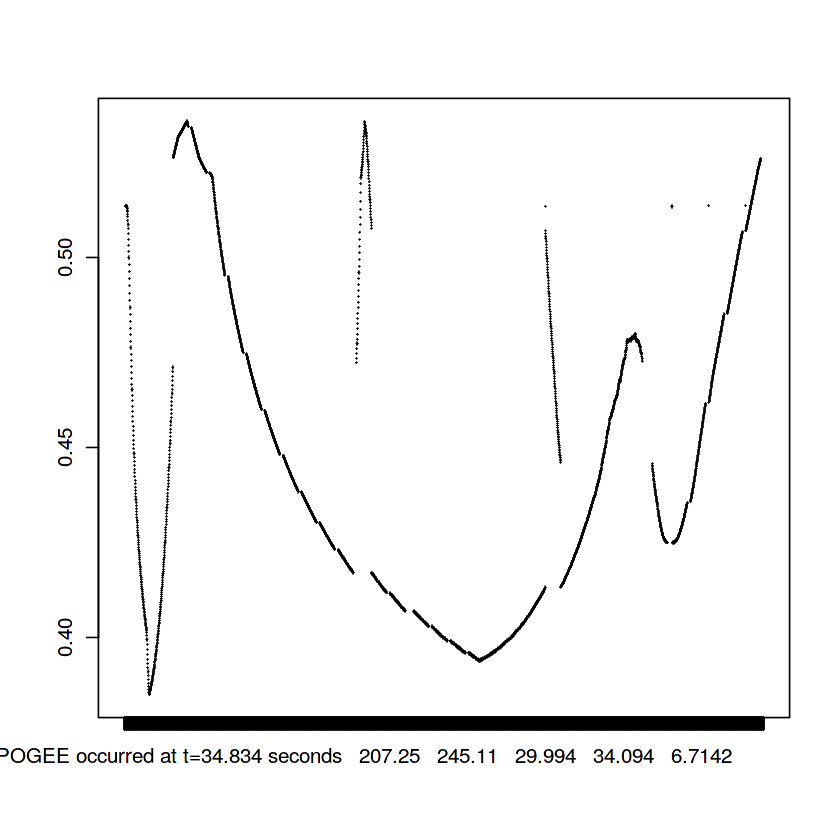

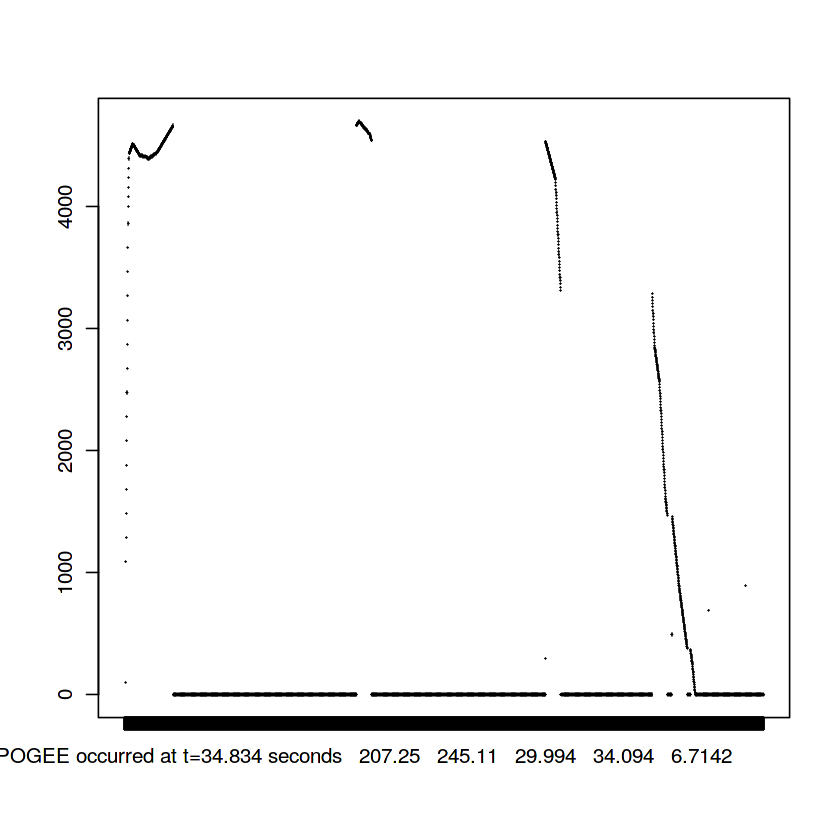

In [17]:
plot(dat.ideal$X..Time..s., dat.ideal$Drag.coefficient...., type='l')
plot(dat.ideal$X..Time..s., dat.ideal$Thrust..N., type='l', col='red')

In [19]:
?system